# Iperf
- https://gitlab.eurecom.fr/oai/openairinterface5g/-/tree/2023.w09/ci-scripts/yaml_files/5g_rfsimulator

### 1. Setup

```bash
docker compose up -d mysql oai-udr oai-udm oai-ausf oai-nrf oai-amf oai-smf oai-spgwu oai-ext-dn
docker ps -a  # Wait until all healthy
docker compose up -d oai-gnb
docker ps -a  # Wait until all healthy
docker compose up -d oai-nr-ue
docker ps -a  # Wait until all healthy
```

### 2. Ping the internet

#### Commands
```bash
docker exec -it oai-ext-dn bash
ifconfig
```
#### Result
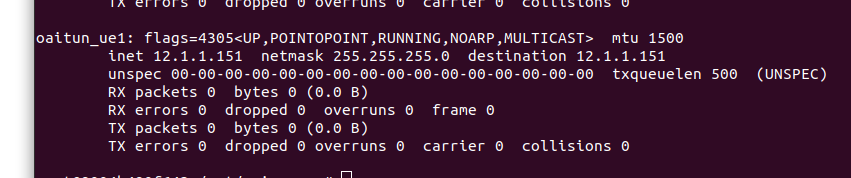

#### Commands
```bash
ping -I oaitun_ue1 -c 10 google.be
```
#### Result
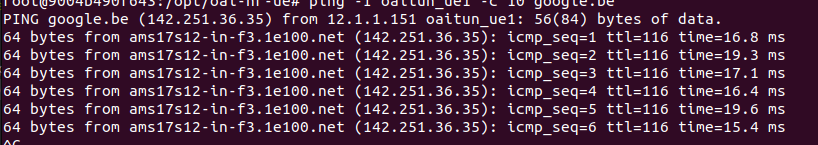

### 3. UDP Iperf with default config

#### Terminal 1
```bash
docker exec -it oai-nr-ue iperf -B 12.1.1.151 -u -i 1 -s
```

#### Terminal 2
```bash
docker exec -it oai-ext-dn iperf -c 12.1.1.151 -u -i 1 -t 20 -b 10G
```

#### Result
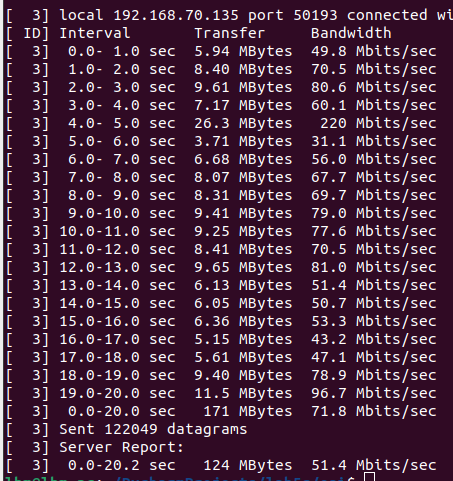

### 4. TCP Iperf with default config

#### Terminal 1
```bash
docker exec -it oai-nr-ue iperf -B 12.1.1.151 -i 1 -s
```

#### Terminal 2
```bash
docker exec -it oai-ext-dn iperf -c 12.1.1.151 -i 1 -t 20
```

#### Result
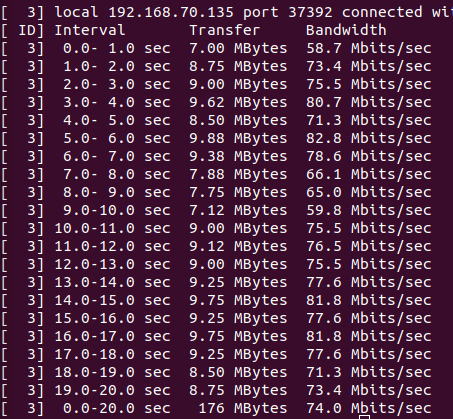

### 5. Can we change the config to get a more representative througput?

#### Sources
- https://gitlab.eurecom.fr/oai/openairinterface5g/-/blob/develop/doc/RUNMODEM.md

#### Edit UE config
- `-C`: downlink carrier frequency in Hz (default value 0) **changed to value 1960000000**
- `--band`: NR band number (default value 78) **changed to value 2**
- `-r`: bandwidth in terms of RBs (default value 106) **changed to value 111**

#### Edit UE service oai-nr-ue
```
USE_ADDITIONAL_OPTIONS: -E --sa --rfsim -r 111 --band 2 --numerology 1 -C 1960000000 --nokrnmod --log_config.global_log_options level,nocolor,time
```

#### Add GNB config oai-gnb
- https://gitlab.eurecom.fr/oai/openairinterface5g/-/blob/develop/docker/README.md#5-running-modems-using-docker-under-ubuntu-1804

in dockerfile: add a `volumes` section
```
volumes:
    - ./conf/gnb.conf:/opt/oai-gnb/etc/gnb.conf
```

in dockerfile: remove
```
USE_SA_TDD_MONO: 'yes'
```
and add
```
USE_VOLUMED_CONF: 'yes'         
```

in `./conf/gnb.conf`: edit
```
dl_carrierBandwidth                                            = 111;  # CHANGED DEFAULT `106`
dl_subcarrierSpacing                                           = 0;    # CHANGED DEFAULT `1`
ul_subcarrierSpacing                                           = 0;    # CHANGED DEFAULT `1`
```

#### Got an error
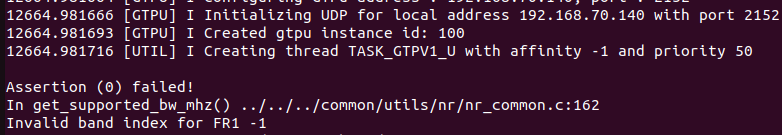

#### Luckily, the gnb executable has debug symbols by default

#### To debug, I did

Overwrite the entrypoint of the `oai-gnb` service in the docker compose with
```
entrypoint: ["tail", "-f", "/dev/null"]
```

Then run
```bash
docker exec -it oai-gnb bash
gdb --args /opt/oai-gnb/bin/nr-softmodem -O /opt/oai-gnb/etc/mounted.conf --sa -E --rfsim --log_config.global_log_options level,nocolor,time
break get_nr_table_idx
run
```
#### Got stuck

### Steal the configuration from `gnb.sa.band66.fr1.106PRB.usrpn300.conf`
This config alligns closely to our use case.

#### Result
Wow, seems computationlly expensive, my PC almost hangs, an `ifconfig` does not display the correct IP address
maybe debug on the idlab server?
